### Author: Michael Polinsky

# Project 5 - Letter Classification

In [176]:
import pandas as pd
import numpy as np
import seaborn as sbn
import scipy as sp
import plotly

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, KFold
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, silhouette_score, silhouette_samples
from sklearn.tree import DecisionTreeClassifier, export_text, export_graphviz
from sklearn.svm import SVC, LinearSVC
from sklearn.cluster import KMeans, DBSCAN

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler, OneHotEncoder

import graphviz

### Importing the data from github

In [328]:
df = pd.read_csv("https://raw.githubusercontent.com/bforoura/AML/master/letters.csv")

# Analysis of data:

In [178]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   x-box   20000 non-null  int64 
 1   y-box   20000 non-null  int64 
 2   width   20000 non-null  int64 
 3   high    20000 non-null  int64 
 4   onpix   20000 non-null  int64 
 5   x-bar   20000 non-null  int64 
 6   y-bar   20000 non-null  int64 
 7   x2bar   20000 non-null  int64 
 8   y2bar   20000 non-null  int64 
 9   xybar   20000 non-null  int64 
 10  x2ybr   20000 non-null  int64 
 11  xy2br   20000 non-null  int64 
 12  x-ege   20000 non-null  int64 
 13  xegvy   20000 non-null  int64 
 14  y-ege   20000 non-null  int64 
 15  yegvx   20000 non-null  int64 
 16  class   20000 non-null  object
dtypes: int64(16), object(1)
memory usage: 2.6+ MB


## All types are int64 except for the target, which is categorical, listed as object because the values are Python strings.

In [179]:
# there are 8 numeric attributes and 1 binary outcome

df.describe()

,x-box,y-box,width,high,onpix,x-bar,y-bar,x2bar,y2bar,xybar,x2ybr,xy2br,x-ege,xegvy,y-ege,yegvx
count,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000
mean,4.023550,7.035500,5.121850,5.37245,3.505850,6.897600,7.500450,4.628600,5.178650,8.282050,6.45400,7.929000,3.046100,8.338850,3.691750,7.80120
std,1.913212,3.304555,2.014573,2.26139,2.190458,2.026035,2.325354,2.699968,2.380823,2.488475,2.63107,2.080619,2.332541,1.546722,2.567073,1.61747
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,3.000000,5.000000,4.000000,4.00000,2.000000,6.000000,6.000000,3.000000,4.000000,7.000000,5.00000,7.000000,1.000000,8.000000,2.000000,7.00000
50%,4.000000,7.000000,5.000000,6.00000,3.000000,7.000000,7.000000,4.000000,5.000000,8.000000,6.00000,8.000000,3.000000,8.000000,3.000000,8.00000
75%,5.000000,9.000000,6.000000,7.00000,5.000000,8.000000,9.000000,6.000000,7.000000,10.000000,8.00000,9.000000,4.000000,9.000000,5.000000,9.00000
max,15.000000,15.000000,15.000000,15.00000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.00000,15.000000,15.000000,15.000000,15.000000,15.00000


## The numeric features here are all in the same range, 0 - 15.

## Our target is 'class', containing the 26 letters of the Latin alphabet.   

In [334]:
df['class'].sort_values().unique()

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
       'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'],
      dtype=object)

## Since the target class is not numeric, I'll encode it with OrdinalEncoder() and check the correlations

In [329]:
oe = OrdinalEncoder()
orded_c = oe.fit_transform(xx.loc[:,'class'].values.reshape(-1, 1))

In [330]:
df['ord_class'] = orded_c
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   x-box      20000 non-null  int64  
 1   y-box      20000 non-null  int64  
 2   width      20000 non-null  int64  
 3   high       20000 non-null  int64  
 4   onpix      20000 non-null  int64  
 5   x-bar      20000 non-null  int64  
 6   y-bar      20000 non-null  int64  
 7   x2bar      20000 non-null  int64  
 8   y2bar      20000 non-null  int64  
 9   xybar      20000 non-null  int64  
 10  x2ybr      20000 non-null  int64  
 11  xy2br      20000 non-null  int64  
 12  x-ege      20000 non-null  int64  
 13  xegvy      20000 non-null  int64  
 14  y-ege      20000 non-null  int64  
 15  yegvx      20000 non-null  int64  
 16  class      20000 non-null  object 
 17  ord_class  20000 non-null  float64
dtypes: float64(1), int64(16), object(1)
memory usage: 2.7+ MB


In [331]:
correlations = df.corr()

In [332]:
target_corr = pd.DataFrame(correlations['ord_class'])

## Plotting the 'target' column of the correlation heatmap.
### Shows the correlation of each feature with the target

<AxesSubplot:>

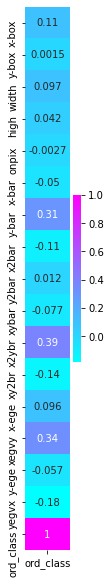

In [333]:
plt.figure(figsize=(1,10)) 
sbn.heatmap(target_corr, cmap='cool', annot=True)

## I don't see any extremely strong correlations among the data here, but it turns out to be interesting that the features 'x-ege' and 'y-ege' are not particularly highly corrleated with 'ord_class'.

## There are 16 unique values for each feature other than the target.

In [335]:
df.nunique()

x-box        16
y-box        16
width        16
high         16
onpix        16
x-bar        16
y-bar        16
x2bar        16
y2bar        16
xybar        16
x2ybr        16
xy2br        16
x-ege        16
xegvy        16
y-ege        16
yegvx        16
class        26
ord_class    26
dtype: int64

array([[<AxesSubplot:title={'center':'x-box'}>,
        <AxesSubplot:title={'center':'y-box'}>,
        <AxesSubplot:title={'center':'width'}>,
        <AxesSubplot:title={'center':'high'}>],
       [<AxesSubplot:title={'center':'onpix'}>,
        <AxesSubplot:title={'center':'x-bar'}>,
        <AxesSubplot:title={'center':'y-bar'}>,
        <AxesSubplot:title={'center':'x2bar'}>],
       [<AxesSubplot:title={'center':'y2bar'}>,
        <AxesSubplot:title={'center':'xybar'}>,
        <AxesSubplot:title={'center':'x2ybr'}>,
        <AxesSubplot:title={'center':'xy2br'}>],
       [<AxesSubplot:title={'center':'x-ege'}>,
        <AxesSubplot:title={'center':'xegvy'}>,
        <AxesSubplot:title={'center':'y-ege'}>,
        <AxesSubplot:title={'center':'yegvx'}>],
       [<AxesSubplot:title={'center':'ord_class'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

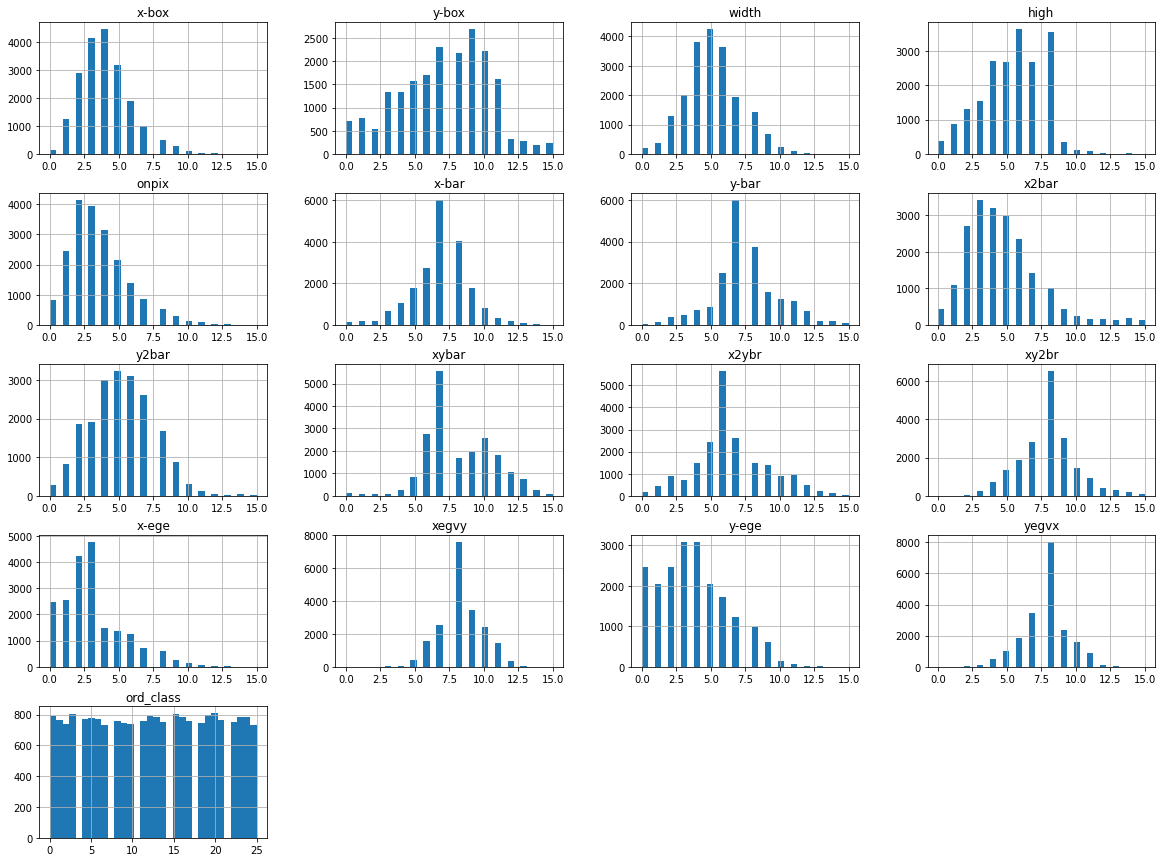

In [336]:
df.hist(bins=32, figsize=(20,15))

## These features are mostly normally distributed, all in range 0 - 15.  I wonder if the StandarScaler would help with the distibutions for y-ege, x-ege, x2bar, onpix, high, and x-box which appear slightly skewed?

# 

#### For step 4, cross_validate_model()

In [337]:
def cross_validate_model(classifier_model, X, y):
    kfold = KFold(n_splits=3, shuffle=True, random_state=10)

    # perform model cross validation on the shuffled folds
    results = cross_val_score(classifier_model, X, y, cv=kfold)

    # return the mean score for all folds
    return results.mean()

# Prepare data for classification by performing transformations such as encoding, imputing, etc but only as needed!

### No missing values to impute.

In [338]:
df.isna().sum().sum()

0

## Encodings:

### Predicting on the ordinally encoded class feature was not helpful, nor was using the OneHotEncoding.  The OrdinalEncoder actually caused the polynomial models to perform worse.

# Plot label freqquencies to verify that the legtters A-Z are well-represented in the dataset.

<AxesSubplot:>

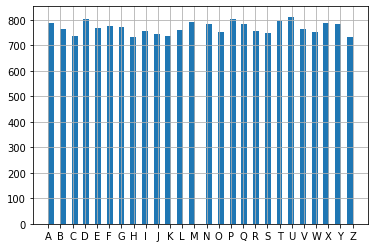

In [339]:
df.loc[:,'class'].sort_values().hist(bins=52)

## There are between 700 and just over 800 instances per label, which is very even.  

# Because I'm not including the encoding stage for training and only using a scaler, I am not using a pipeline.

### Removing 'class' and 'ord_class' from the data and assigning 'class' to Y.

In [340]:
X = df.drop(columns=['class', 'ord_class'])
Y = df.loc[:,'class']

In [341]:
trainX, testX, trainY, testY = train_test_split(X, Y, train_size = 0.80, 
                                                      test_size = 0.20,
                                                      random_state = 101) # was previously 1

## Scaling with MinMaxScaler.
### Scaling does not affect the tree models, or the linear, polynomial, or rbf kernel SVCs but did help the SGDClassifier and LinearSVM models, though neither of those two were among the best performing ultimately.
### I also tried StandardScaler. With StandardScaler the models performed identically as with MinMaxScaler, except for the linear SVM and the SGDClassifier, which performed worse.  


In [342]:
mms = MinMaxScaler()

In [343]:
trainX = mms.fit_transform(trainX)
testX = mms.transform(testX)

# Create a variety of classification models suchas DT, RF, ExtraTrees, SVM, SGD, etc. and train each model separately and validate using cross_validate_model()

# Decision Tree

In [344]:
dt_clf = DecisionTreeClassifier(criterion='entropy',
                       random_state=14)

In [345]:
dt_trn_score = cross_validate_model(dt_clf, trainX, trainY)
dt_tst_score = cross_validate_model(dt_clf, testX, testY)
print(dt_trn_score)
print(dt_tst_score)

0.8603745575305806
0.7525063424776733


# Random Forest

In [346]:
rf_clf = RandomForestClassifier(n_estimators=1000, 
                       criterion='gini', 
                       max_depth=None, min_samples_split=2, 
                       max_features='auto', 
                       n_jobs=None, 
                       random_state=100, 
                       verbose=0, 
                       warm_start=False)

In [347]:
rf_trn_score = cross_validate_model(rf_clf, trainX, trainY)
rf_tst_score = cross_validate_model(rf_clf, testX, testY)
print(rf_trn_score)
print(rf_tst_score)

# Unscaled Scores: 
#          0.9518121949550981
#          0.8835004853162317

0.9568749410730183
0.891751985972505


# Extratrees

In [348]:
xt_clf = ExtraTreesClassifier(n_estimators=1000,     
                     criterion='gini',                     
                     max_depth=None,                   
                     n_jobs=None,                         
                     random_state=None,                     
                     verbose=0,
                     warm_start=False)                      

# Unscaled score:
#            0.9650624020769202    
#            0.906250738096818

In [349]:
xt_trn_score = cross_validate_model(xt_clf, trainX, trainY)
xt_tst_score = cross_validate_model(xt_clf, testX, testY)
print(xt_trn_score)
print(xt_tst_score)

0.9656248434912259
0.908751175799947


# SGD 

In [377]:
sgd_clf = SGDClassifier(loss='hinge',
              penalty='l2',
              random_state=101)

In [378]:
sgd_trn_score = cross_validate_model(sgd_clf, trainX, trainY)
sgd_tst_score = cross_validate_model(sgd_clf, testX, testY)
print(sgd_trn_score)
print(sgd_tst_score)

# unscaled scores: 
#       0.5451210591925588
#       0.45676880239550144

0.6101277819365023
0.5889963870277914


# SVCs

#### LinearSVC
#### Here I found that not attempting to find optimal hyperparameters was the optimal strategy.

In [373]:
ln1_svc = LinearSVC()

In [374]:
ln1_trn_score = cross_validate_model(ln1_svc, trainX, trainY)
ln1_tst_score = cross_validate_model(ln1_svc, testX, testY)
print(ln1_trn_score)
print(ln1_tst_score)

# unscaled scores: 
#       0.6863746381974146
#       0.6750013965260431

0.6961258452294063
0.6852498356973052


#### Linear kernel SVC  This model gave me the hardest time.  As you can see scaling did not improve the scores, but changing the random seed seems to have a large effect.

In [383]:
ln2_svc = SVC(kernel='linear', 
               gamma='scale', 
               random_state=110)

In [384]:
ln2_trn_score = cross_validate_model(ln2_svc, trainX, trainY)
ln2_tst_score = cross_validate_model(ln2_svc, testX, testY)
print(ln2_trn_score)
print(ln2_tst_score)

# unscaled scores: 
#       0.8481244715027535
#       0.8117505388341089

0.8105004359922852
0.7400037790557086


#### Poly deg=3, C=1.0

In [356]:
ply1_svc = SVC(kernel='poly', 
                 C=1.0, 
                 degree=3, 
                 gamma='scale', 
                 verbose=False, 
                 max_iter=- 1, 
                 decision_function_shape='ovr', 
                 random_state=4)

In [357]:
ply1_trn_score = cross_validate_model(ply1_svc, trainX, trainY)
ply1_tst_score = cross_validate_model(ply1_svc, testX, testY)
print(ply1_trn_score)
print(ply1_tst_score)

# unscaled scores: 
#      0.9349370424890401
#      0.8747499843476612

0.9371251127829909
0.876501171769704


#### Poly deg=4, C=0.1

In [358]:
ply2_svc = SVC(kernel='poly', 
             C=0.1, 
             degree=4, 
             gamma='scale', 
             random_state=42)

# unscaled scores: 
#       0.9362495893713643
#       0.8780006095976768

In [359]:
ply2_trn_score = cross_validate_model(ply2_svc, trainX, trainY)
ply2_tst_score = cross_validate_model(ply2_svc, testX, testY)
print(ply2_trn_score)
print(ply2_tst_score)

0.9378126206003735
0.8777509219883681


#### rbf

In [360]:
rbf_svc = SVC(kernel='rbf',
              C=100.0,  
              gamma='scale', 
              verbose=False, 
              max_iter=- 1, 
              decision_function_shape='ovr', 
              random_state=None)

# unscaled scores: 
#       0.9622496911306301
#       0.9077509257374313

In [361]:
rbf_trn_score = cross_validate_model(rbf_svc, trainX, trainY)
rbf_tst_score = cross_validate_model(rbf_svc, testX, testY)
print(rbf_trn_score)
print(rbf_tst_score)
#96/90

0.9604373122026538
0.9130011138466777


## Model Performance
### The Random Forest, Extra Trees, SVC Poly kernels and SVC rbf kernel models performed the best.  The linear models were all the worse, though the SVC with a linear kernel was almost as good as the decision tree.

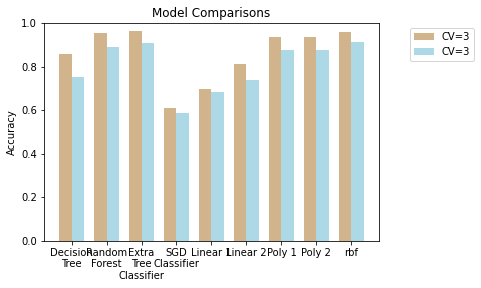

In [385]:
# Summarize the findings for all models

labels = ['Decision\nTree','Random\nForest','Extra\nTree\nClassifier', 'SGD\nClassifier', 'Linear 1\n', 'Linear 2\n', 'Poly 1\n','Poly 2\n', 'rbf']
training_scores = [dt_trn_score, rf_trn_score, xt_trn_score, sgd_trn_score, ln1_trn_score, ln2_trn_score, ply1_trn_score, ply2_trn_score, rbf_trn_score]
test_scores = [dt_tst_score, rf_tst_score, xt_tst_score, sgd_tst_score, ln1_tst_score, ln2_tst_score, ply1_tst_score, ply2_tst_score, rbf_tst_score]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, training_scores, width, label='CV=3', color='tan')
rects2 = ax.bar(x + width/2, test_scores, width, label='CV=3', color='lightblue')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_xticks(x)
ax.set_ylim(0,1)
ax.set_xticklabels(labels)
ax.legend(bbox_to_anchor = (1.3, 1.0), loc='upper right')

plt.title('Model Comparisons')
plt.show()

# Train the voting classifier model and cross-validate as shown above.

In [386]:
voting_clf = VotingClassifier(
    estimators=[('rf', rf_clf), ('xt', xt_clf),  ('svc', rbf_svc)],
    voting='hard')

In [387]:
vote_trn_score = cross_validate_model(voting_clf, trainX, trainY)
vote_tst_score = cross_validate_model(voting_clf, testX, testY)
print(vote_trn_score)
print(vote_tst_score)

0.9657499098943028
0.9115011136592245


## Voting Classifier: 91.15% vs 91.30% for the SVC with the rbf kernel.  

# Plot the obtained Accuracy scores un a bar chart.  Has the voting classifier outperformed each individual model?  Explain why or why not.

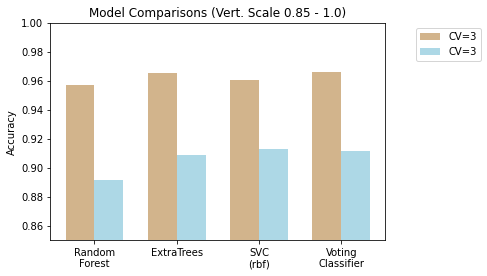

In [392]:
# Summarize the findings for all models

labels = ['Random\nForest', 'ExtraTrees', 'SVC\n(rbf)', 'Voting\nClassifier']
train_scores = [rf_trn_score, xt_trn_score, rbf_trn_score, vote_trn_score]
test_scores = [rf_tst_score, xt_tst_score, rbf_tst_score, vote_tst_score]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, train_scores, width, label='CV=3', color='tan')
rects2 = ax.bar(x + width/2, test_scores, width, label='CV=3', color='lightblue')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_xticks(x)
ax.set_ylim(0.85,1)
ax.set_xticklabels(labels)
ax.legend(bbox_to_anchor = (1.3, 1.0), loc='upper right')

plt.title('Model Comparisons (Vert. Scale 0.85 - 1.0)')
plt.show()

### The voting classifier is actually slightly behind the best single classifier. This may be because there was not a diverse enough mix of models.  The ExtraTrees and RandomForest classifiers are similar models, but these three were clearly the best.  I also added the best SVC polynomial model and saw no improvement. 

# 7. Plot feature_importances discovered by the Random forest model to get a plot similar to this one....see notes.  

### Random Forest Importance

Feature: 0, Score: 0.02234
Feature: 1, Score: 0.02519
Feature: 2, Score: 0.02251
Feature: 3, Score: 0.02024
Feature: 4, Score: 0.02662
Feature: 5, Score: 0.05135
Feature: 6, Score: 0.06816
Feature: 7, Score: 0.08411
Feature: 8, Score: 0.09315
Feature: 9, Score: 0.07380
Feature: 10, Score: 0.08080
Feature: 11, Score: 0.08422
Feature: 12, Score: 0.11897
Feature: 13, Score: 0.07430
Feature: 14, Score: 0.09993
Feature: 15, Score: 0.05432


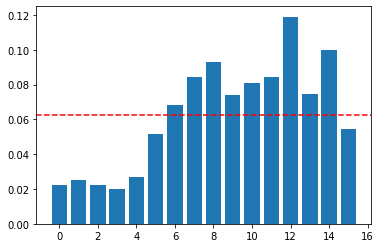

In [389]:
rf_clf.fit(trainX, trainY)

# get feature importances from the model
rf_imp = rf_clf.feature_importances_

# summarize feature importances
for i,v in enumerate(rf_imp):
	print('Feature: %0d, Score: %.5f' % (i,v))
 
# plot feature importances
plt.bar([x for x in range(len(rf_imp))], rf_imp)
plt.axhline(y=0.0625, c='red', linestyle='--')
plt.show()

### DTree

Feature: 0, Score: 0.00700
Feature: 1, Score: 0.00999
Feature: 2, Score: 0.00414
Feature: 3, Score: 0.00626
Feature: 4, Score: 0.00833
Feature: 5, Score: 0.02312
Feature: 6, Score: 0.06921
Feature: 7, Score: 0.07707
Feature: 8, Score: 0.08939
Feature: 9, Score: 0.06705
Feature: 10, Score: 0.06087
Feature: 11, Score: 0.09310
Feature: 12, Score: 0.17521
Feature: 13, Score: 0.08737
Feature: 14, Score: 0.15785
Feature: 15, Score: 0.06404


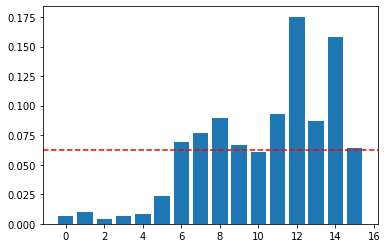

In [390]:
dt_clf.fit(trainX, trainY)

# get feature importances from the model
dt_imp = dt_clf.feature_importances_

# summarize feature importances
for i,v in enumerate(dt_imp):
	print('Feature: %0d, Score: %.5f' % (i,v))
 
# plot feature importances
plt.bar([x for x in range(len(dt_imp))], dt_imp)
plt.axhline(y=0.0625, c='red', linestyle='--')
plt.show()

### ExtraTreesClassifier

Feature: 0, Score: 0.02437
Feature: 1, Score: 0.02473
Feature: 2, Score: 0.02620
Feature: 3, Score: 0.02175
Feature: 4, Score: 0.02965
Feature: 5, Score: 0.05542
Feature: 6, Score: 0.06967
Feature: 7, Score: 0.09086
Feature: 8, Score: 0.09121
Feature: 9, Score: 0.07432
Feature: 10, Score: 0.08034
Feature: 11, Score: 0.08440
Feature: 12, Score: 0.10324
Feature: 13, Score: 0.07021
Feature: 14, Score: 0.09777
Feature: 15, Score: 0.05586


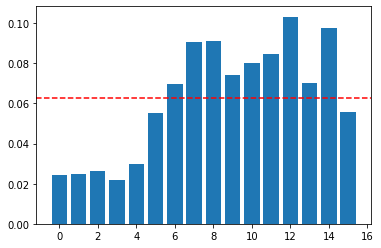

In [391]:
xt_clf.fit(trainX, trainY)

# get feature importances from the model
xt_imp = xt_clf.feature_importances_

# summarize feature importances
for i,v in enumerate(xt_imp):
	print('Feature: %0d, Score: %.5f' % (i,v))
 
# plot feature importances
plt.bar([x for x in range(len(xt_imp))], xt_imp)
plt.axhline(y=0.0625, c='red', linestyle='--')
plt.show()

### The height of these bars tells us the importance of each feature relative to the others.  Importance is determined by the magnitude of the decrease in impurity (measured with Gini) that a feature is responsible for, i.e. how much order does the feature impose on the decision process?  Features with a higher importance do more to sort out the decision paths.  The importances all add to one, meaning they can't all be the max value, at most they could each be 1/number of features, in this case 0.625, which is where the horizontal line is plotted.  That is where all bars would be in al featuers were equally important..  The x-ticks correspond to the indices of the features in the training data, meaning that the important features for the RF are.
### They all agree generally, though not exactly -- they differ in their scores and relative importances.  Here all three agree that features 12 and 14 are the most important. The RF and the ExtraTreesClassifier both score features 7 and 8 more highly than their neighbors -- a clear second place cluster of features, while the DTree rates feature 11 as the second most important after 12 and 14, and rates 6 and 7 equal in importance with 8 barely higher than those two.  So perhaps the more powerful ExtraTreesClassifier and RF area able to discern importance better by virtue of using many trees instead of just one, which makes sense.

# Train K-Means on the dataset and plot the elbow and Silhouette inertia values and explain the results.

In [315]:
def plot_clusters(trainX, y=None):
    plt.scatter(trainX['y2bar'], trainY, s=1)

## Here I'm training KMeans models with up to 26 clsuters and seeing how they score

#### This method comes from the notebook for the text.

In [319]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(trainX)
                for k in range(1, 27)]
inertias = [model.inertia_ for model in kmeans_per_k]

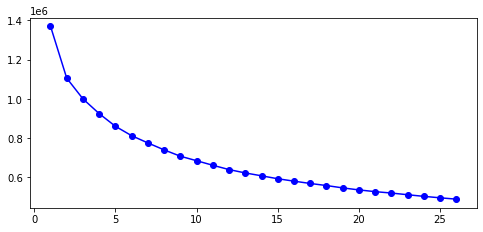

In [411]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 27), inertias, "bo-")
plt.show()

### This plot shows a fairly consistent decline in inertia.

In [321]:
silhouette_scores = [silhouette_score(trainX, model.labels_)
                     for model in kmeans_per_k[1:]]

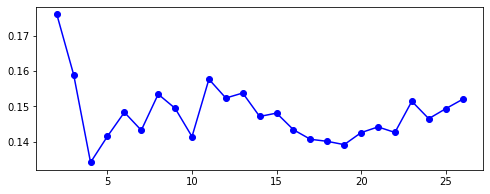

In [410]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 27), silhouette_scores, "bo-")
plt.show()

### Unexpected: Look how poorly it does at 4!

## This graph indicates that 2, 3, and then 11 clusters would be the best number of clusters to use.
## Here are silhouette diagrams for k= 11, 3, 4, 5, and 6.

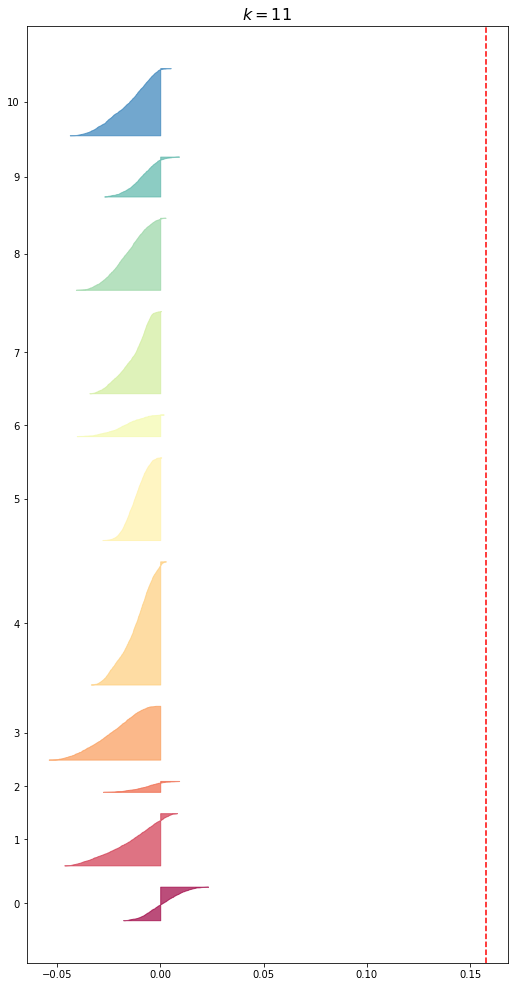

In [408]:
plt.figure(figsize=(50, 100))

plt.subplot(5, 5, 9)
    
y_pred = kmeans_per_k[10].labels_
silhouette_coefficients = silhouette_samples(trainX, y_pred)

padding = len(trainX) // 30
pos = padding
ticks = []
for i in range(11):
    coeffs = silhouette_coefficients[y_pred == i]
    coeffs.sort()

    color = mpl.cm.Spectral(i / 11)
    plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                      facecolor=color, edgecolor=color, alpha=0.7)
    ticks.append(pos + len(coeffs) // 2)
    pos += len(coeffs) + padding

plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
plt.gca().yaxis.set_major_formatter(FixedFormatter(range(11)))
plt.tick_params(labelbottom=True)

plt.axvline(x=silhouette_scores[9], color="red", linestyle="--")
plt.title("$k={}$".format(11), fontsize=16)

plt.show()

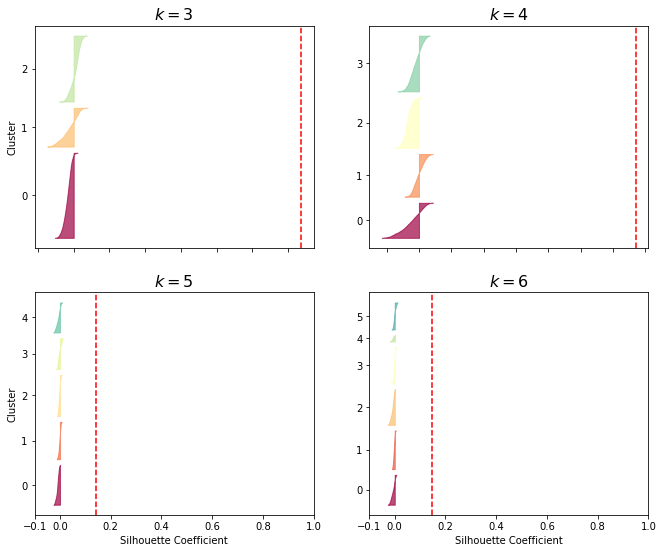

In [409]:
plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(trainX, y_pred)

    padding = len(trainX) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()

## And this is the silhouette diagram for k=26

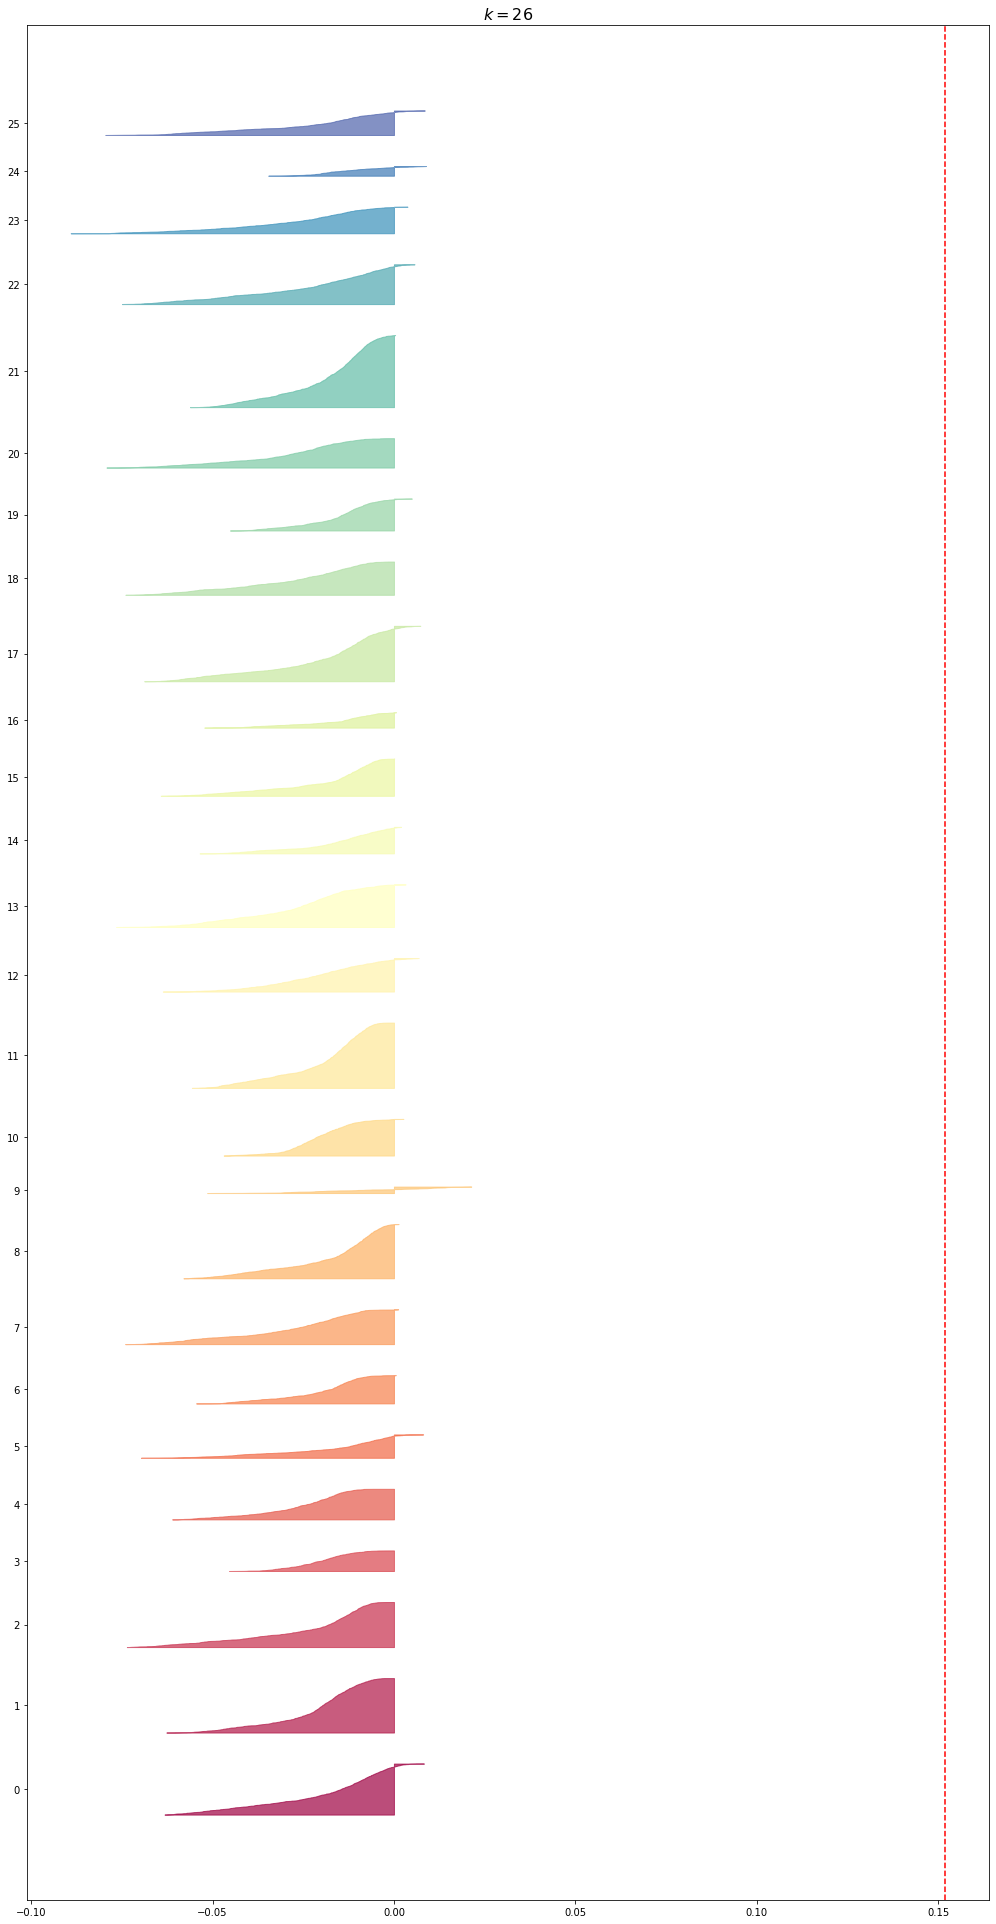

In [405]:
plt.figure(figsize=(100, 200))

plt.subplot(5, 5, 24)
    
y_pred = kmeans_per_k[25].labels_
silhouette_coefficients = silhouette_samples(trainX, y_pred)

padding = len(trainX) // 30
pos = padding
ticks = []
for i in range(26):
    coeffs = silhouette_coefficients[y_pred == i]
    coeffs.sort()

    color = mpl.cm.Spectral(i / 26)
    plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                      facecolor=color, edgecolor=color, alpha=0.7)
    ticks.append(pos + len(coeffs) // 2)
    pos += len(coeffs) + padding

plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
plt.gca().yaxis.set_major_formatter(FixedFormatter(range(26)))
plt.tick_params(labelbottom=True)

plt.axvline(x=silhouette_scores[24], color="red", linestyle="--")
plt.title("$k={}$".format(26), fontsize=16)

plt.show()

### These silhouettes are all terrible.  They are a great example of the opposite of what we want from our classifier. Most of the instances lie to the left of both 0 and the silhouette score line, reflecting that the data is almost entirely misclassified.  It's worth noting that the silhouette coefficient is only about 0.15, closer to 0 than 1 and suggesting that few instances in the clusters lie close to their centroids.

### So what do we think when a clustering algorithm isn't detecting the number of clusters that we think it should?  One possiblity is that KMeans may not be the algorithm for this dataset, that perhaps this data does not contain approximately circular clusters of roughly equal diameter.  
### If we saw good clustering at less than the number of clusters we expect, such as 2, 3, or 11  instead of 26, another possiblity is that the best way to use a clustering algorithm on this data would be for feature reduction, before letting another algorithm do the rest of the work. 

# Create a 3D plot of the target concept against the two most inluential features from step 7.  How does the visualized data match the results obtained there?

## Here is a 2D plot of the two most important features.

<AxesSubplot:xlabel='x-ege', ylabel='y-ege'>

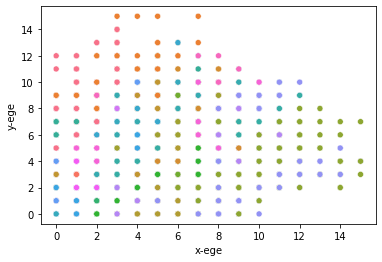

In [325]:
sbn.scatterplot(data=df, x='x-ege', y='y-ege', hue="class" , legend=False)

## And here is a 3D plot of those features against the target, seen from the same angle as the 2D plot: no clear pattern...

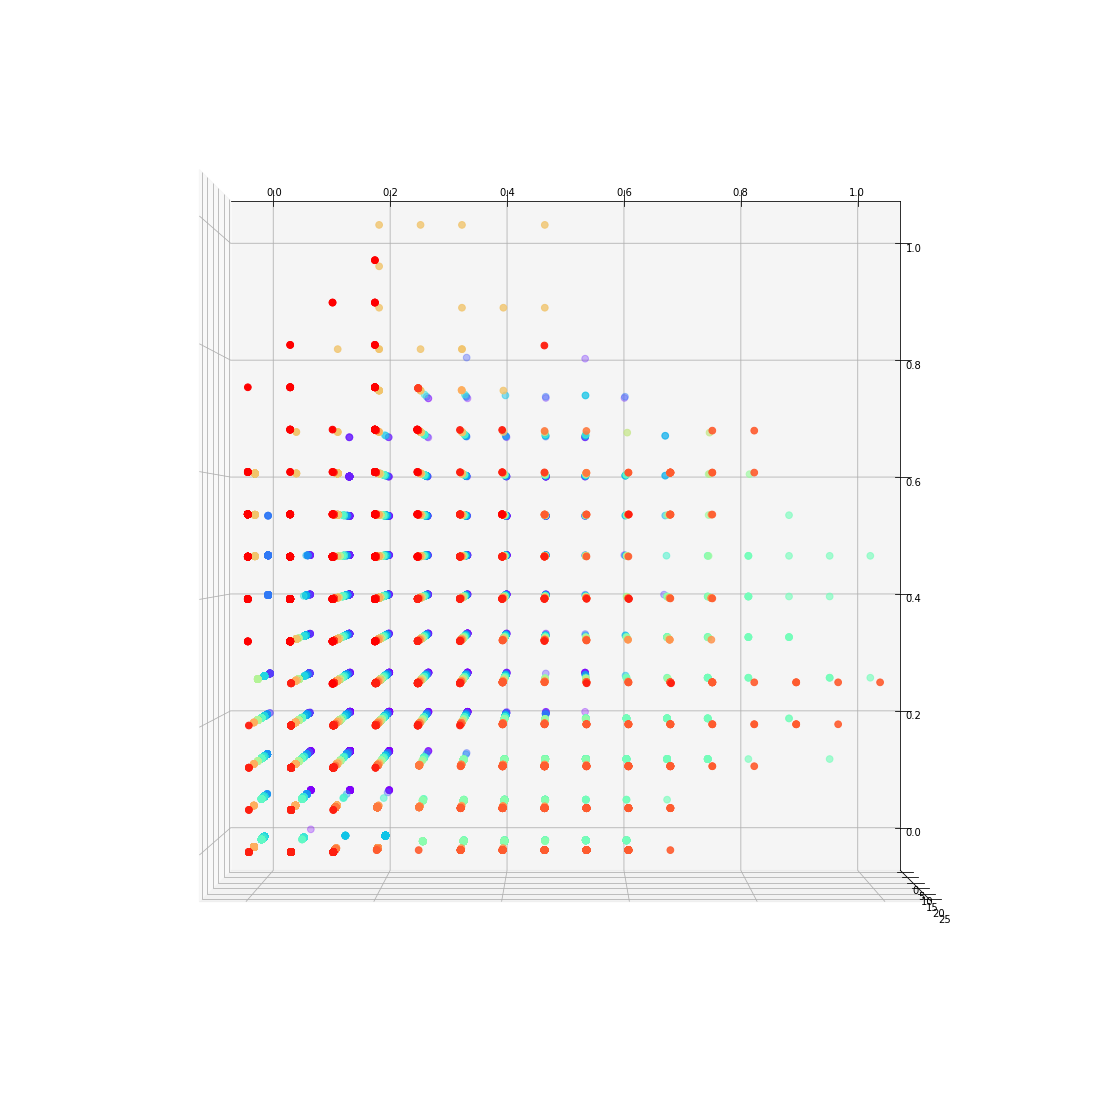

In [393]:
fig = plt.figure(figsize=(20,20))
ax = plt.axes(projection='3d')

enc = OrdinalEncoder()
z = enc.fit_transform(trainY.values.reshape(-1,1))

xdata = trainX[:,12]
ydata = trainX[:,14]
zdata = z

# Set up data for three-dimensional scattered points; use the 26 labels for color map
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='rainbow', s=45)

# rotate the axes and update the viewcb
ax.view_init(90, 270)
plt.draw()

## Now if we rotate this we see:

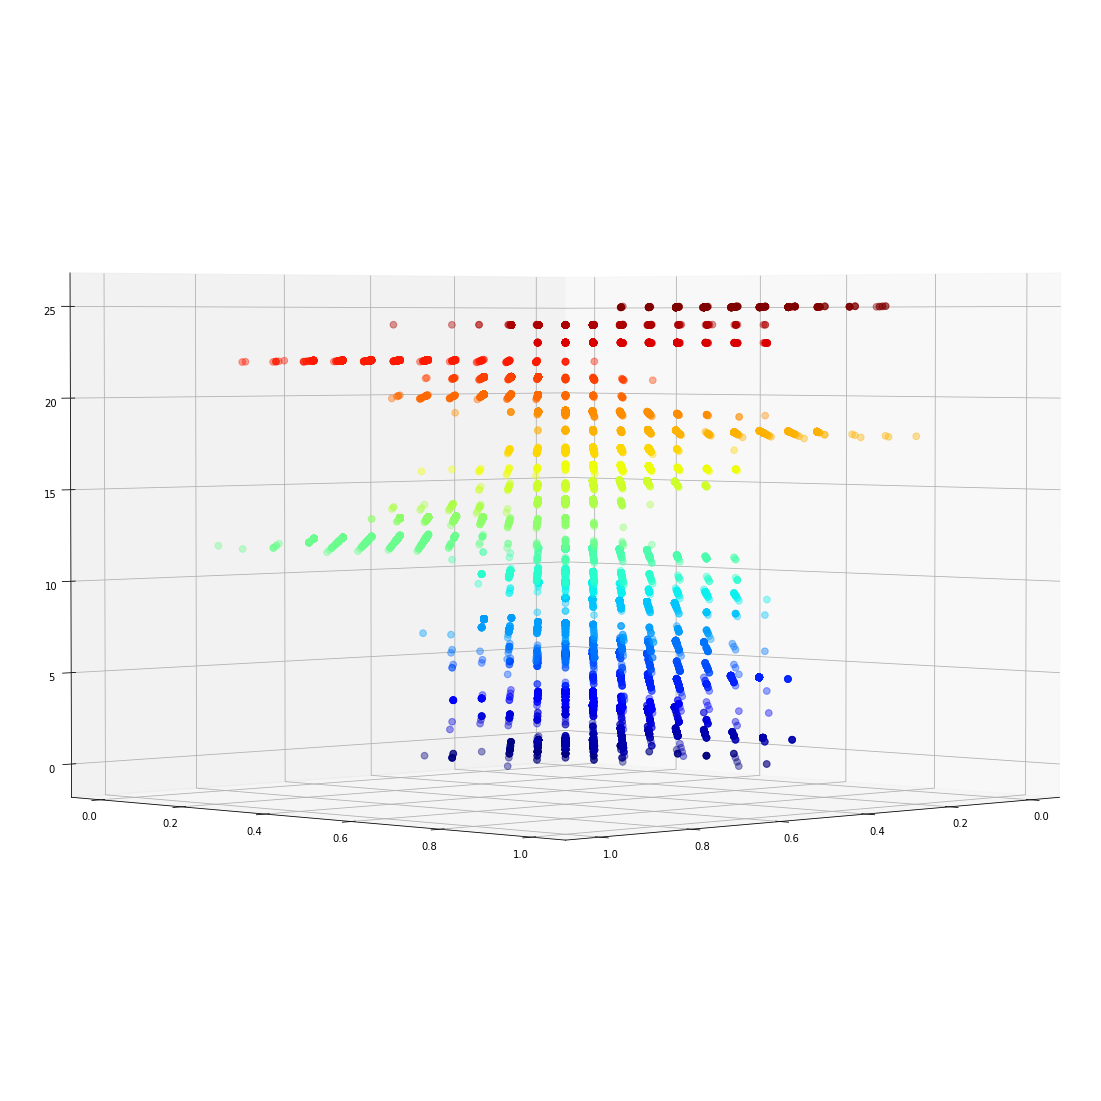

In [406]:
fig = plt.figure(figsize=(20,20))
ax = plt.axes(projection='3d')

enc = OrdinalEncoder()
z = enc.fit_transform(trainY.values.reshape(-1,1))

xdata = trainX[:,12]
ydata = trainX[:,14]
zdata = z

# Set up data for three-dimensional scattered points; use the 26 labels for color map
ax.scatter3D(xdata, ydata, zdata, alpha=0.4, c=zdata, cmap='jet', s=45)

# rotate the axes and update the viewcb
ax.view_init(2, 45)
plt.draw()

## To understand what I was looking for here I plotted the two least important features against the target, for comparison:

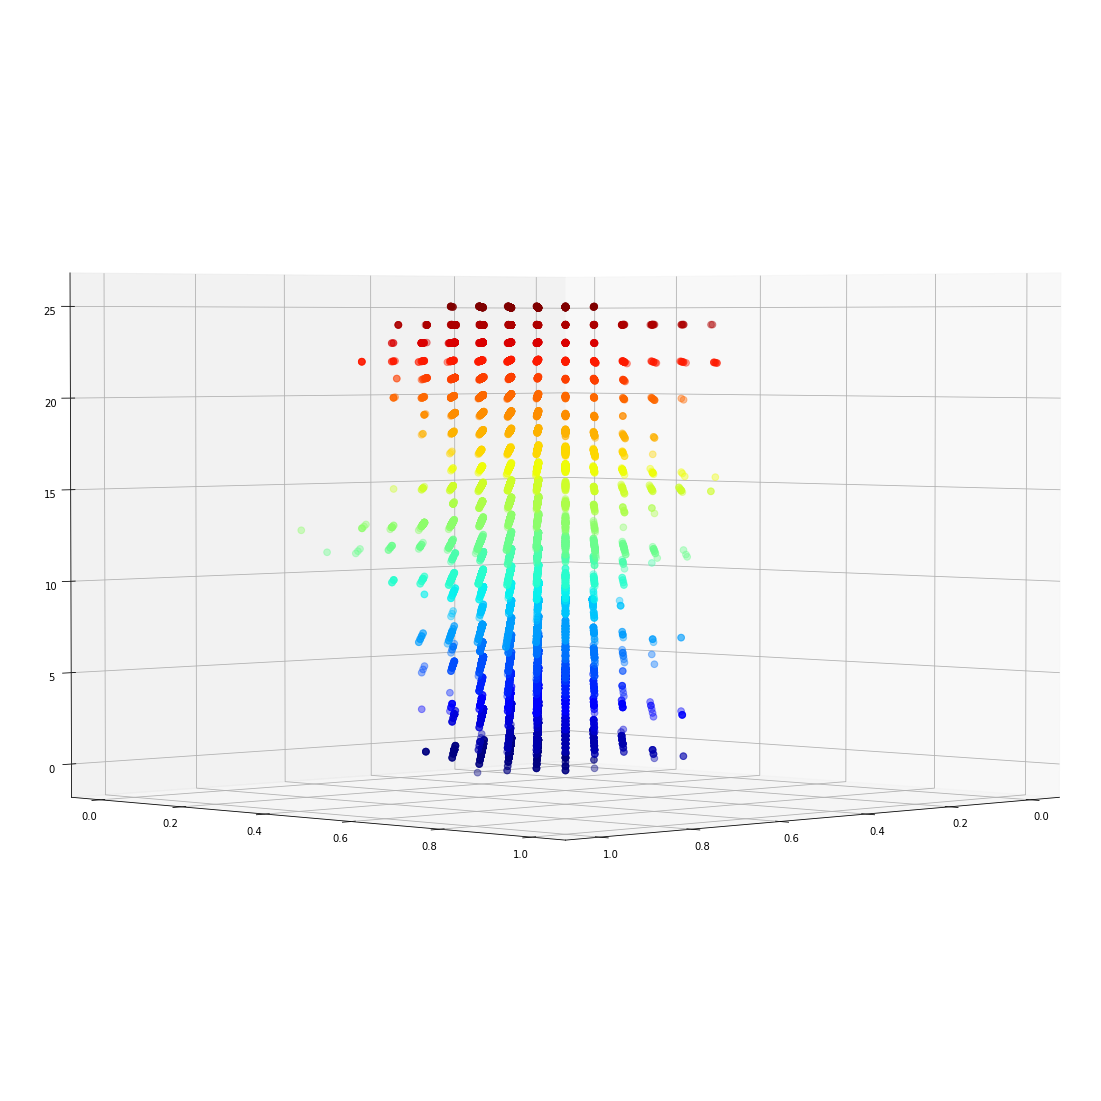

In [395]:
fig = plt.figure(figsize=(20,20))
ax = plt.axes(projection='3d')

enc = OrdinalEncoder()
z = enc.fit_transform(trainY.values.reshape(-1,1))

xdata = trainX[:,2]
ydata = trainX[:,4]
zdata = z

# Set up data for three-dimensional scattered points; use the 26 labels for color map
ax.scatter3D(xdata, ydata, zdata, alpha=0.4, c=zdata, cmap='jet', s=45)

# rotate the axes and update the viewcb
ax.view_init(2, 45)
plt.draw()

## When I look at the two graphs I see that the strata in the most important features plot are more differentiated from one another than in the least important featuers plot. That means there is greater variance in the most important elements than in the least, when they're mapped against the target.  
## In simpler terms, as you go from the bottom to the top of the graph along the axis of the features we're predicting, you experience more change per target class in the plot of the two most importnat features than any others.  That is consistent with what the visualization in step 7 showed.  This is interesting be cuase at the top of the notebook, when I calculated the correlations between the features and the target, these features did not stick out.  Clearly some methods of visualization don't reveal what others do.  

# Summary

## For this project I first checked to see whether data for classification needed to be processed and found that only minimal processing was necessary.  I used a MinMaxScaler to scale the data, though all features' values were in the same range.
## Next I created a voting classifier by first creating several models and then choosing the best to vote as a group.  I found that scaling the data had helped the SGDClassifier, the LinearSVC, and the SVC with a linear kernal, but did not improve them to the point that they reached the group of top models.  The best models were the Random Forest, the ExtraTrees, and the SVC with an rbf kernel, all scoring in the high 80s to low 90s on test set accuracy.  However, when I combined the classifiers, I found that the voting classifier was almost equal but slightly worse than the ExtraTreesClassifier.  I suspect that the problem was nothaving enough diversity in the models I used.  If I were to continue from here, I would try to get better results from the other SVC models, and the SGD classifier, in order to bring in another, more different model to the group.

## For the KMeans section of the project, I created KMeans classifiers using 2 to 26 clusters, thinking that 26 would be the ideal number.  I found low silhouette coefficients and the silhouette diagrams showed poor classification, with instances spread far from their centers.
## Finally I used a 3D scater plot to visualize the two most important features identified in step 7 and observed that these features had a lot more ariation between the target labels than the least important feautres did.
### One question the KMeans section left me with was whether it is generally practical to check for clusters through visualization, or if that is only something we can do with toy datasets designed to show clear clusters in 2-D? In the 3D scatter plot, I observed the differences along the target axis but I did not see clusters that I would expect KMeans to be able to discover.  

# 